In [1]:
import numpy as np
import pandas as pd
import json
from pandas.io.json import json_normalize

# Get the top 4 actors/cast of the movie and the writer and director of the movie

credits = pd.read_csv("unpacked_tmdb_credits.csv", index_col = 0)

In [2]:
# Unchanged code from before - removed the normailizing part as it was not required for any methods used.
# Also all the production houses have been kept as it is since 
# creating a big production house variable is really difficult as the production house names 
# don't match for every movie as they can be subsidiaries or just abbreviated names and all
metadata=pd.read_csv("movie_metadata_with_score_metacritic.csv", index_col="Unnamed: 0") #reading in metacritic dataset
metadata=metadata.loc[~metadata["metacritic_metascore"].isna()] #removing rows with no metacritic data
metadata=metadata.drop(["homepage","keywords","overview","status","tagline","imdb_metascore","budget","revenue"],1) #dropping unnecessary features
metadata=metadata.drop_duplicates() #dropping duplicates
metadata["release_year"]=metadata.release_date.str[0:4].astype(int) #creating new column with year for comparison

num_data=pd.read_csv("the_numbers_budget.csv") #reading in revenue data
num_data=num_data.rename(columns={"Movie":"title"}) #renaming column to match metadata
num_data["num_year"]=num_data["Release Date"].str[-4:].astype(int)
num_data=num_data.drop_duplicates()#dropping duplicates

critic_revenue=metadata.merge(num_data,on="title") #merging datasets
critic_revenue=critic_revenue.drop_duplicates() #dropping duplicates
critic_revenue=critic_revenue.loc[(critic_revenue["Worldwide Gross"]!=0)] #removing rows with no revenue data
critic_revenue=critic_revenue.loc[(np.abs(critic_revenue.release_year-critic_revenue.num_year)<5)] #removing rows where the years don't match, as this indicates different movies

# Reindex since the dataset has been subset many times
critic_revenue.index=range(len(critic_revenue))

In [3]:
#These are the columns we may not model on
keep_list=critic_revenue.columns

# Goal is to create dummy variables from different columns with json string

for movie_num in range(len(critic_revenue)):
    flat_json=json.loads(critic_revenue.loc[movie_num,'production_companies'])
    for index_json in range(len(flat_json)):
        critic_revenue.loc[movie_num,flat_json[index_json]['name']] = 1

prod_company_list = [column for column in critic_revenue.columns if column not in keep_list]        

for movie_num in range(len(critic_revenue)):
    flat_json=json.loads(critic_revenue.loc[movie_num,'genres'])
    for index_json in range(len(flat_json)):
        critic_revenue.loc[movie_num,flat_json[index_json]['name']] = 1

genres_list = [column for column in critic_revenue.columns if column not in keep_list and column not in prod_company_list]        

In [4]:
critic_cast_revenue=critic_revenue.merge(credits,left_on ="id",right_on="movie_id",how="left")

In [5]:
model_cols = [column for column in critic_cast_revenue.columns if column not in keep_list]

# Need to fill the NaN/Missing values with 0 for dummy variable
for column in model_cols:
    critic_cast_revenue[column].fillna(0,inplace=True)



In [6]:
# The positive, mixed and negative review tags are based on the metascore description given by metacritic
critic_cast_revenue['Good Critic Review'] = [1 if critic_cast_revenue.loc[i,'metacritic_metascore'] > 60 else 0 if critic_cast_revenue.loc[i,'metacritic_metascore'] > 40 else -1 for i in range(len(critic_cast_revenue)) ]

critic_cast_revenue["Production Budget Norm"]=(critic_cast_revenue["Production Budget"]-critic_cast_revenue["Production Budget"].median())/critic_cast_revenue["Production Budget"].std()

model_cols.append('Production Budget Norm')

critic_cast_revenue["Log Production Budget"] = np.log(critic_cast_revenue["Production Budget"])
critic_cast_revenue["Log Worldwide Gross"] = np.log(critic_cast_revenue["Worldwide Gross"])
critic_cast_revenue["Log Production Budget Norm"]=(critic_cast_revenue["Log Production Budget"]-critic_cast_revenue["Log Production Budget"].mean())/critic_cast_revenue["Log Production Budget"].std()
 
model_cols.append('Log Production Budget Norm')

In [7]:
from scipy import stats
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor as knn_reg
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor as rf
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import Ridge

In [44]:
class Prop_Score_Matching:
    
    def __init__(self, data, target, C_values, columns):
        self.review_data = data
        self.target = target
        self.C_values = C_values
        self.model_cols = columns
        
    def dividing(self):
        self.review_data.loc[:,'random'] = np.random.random(len(self.review_data))
        train_log=self.review_data.loc[self.review_data['random']<=0.7,:].copy()
        test_log = self.review_data.loc[self.review_data['random']>0.7,:].copy()
        return test_log,train_log

    def propensityScore(self,train_log,test_log):
        log_model = GridSearchCV(LogisticRegression(), param_grid={'C':self.C_values},scoring='roc_auc',cv=5)
        log_model.fit(train_log.loc[:,self.model_cols],train_log[self.target])
        test_log.loc[:,'prop_score'] = log_model.predict_proba(test_log.loc[:,self.model_cols])[:,1]
        
    def kNNMatch(self, test_log): 
        a_review_test=test_log.loc[test_log[self.target]==1,:].copy()
        b_review_test=test_log.loc[test_log[self.target]==0,:].copy()
        knn_model = knn_reg(n_neighbors=1)
        knn_model.fit(np.array(a_review_test['prop_score']).reshape(-1,1),a_review_test.loc[:,"Log Worldwide Gross"])
        b_review_test.loc[:,"y_1"] = knn_model.predict(np.array(b_review_test.loc[:,'prop_score']).reshape(-1,1))
        knn_model.fit(np.array(b_review_test.loc[:,'prop_score']).reshape(-1,1),b_review_test.loc[:,"Log Worldwide Gross"])
        a_review_test.loc[:,"y_0"] = knn_model.predict(np.array(a_review_test.loc[:,'prop_score']).reshape(-1,1))
        return a_review_test, b_review_test

    def paired_t_test(self, a_review_test,b_review_test): 
        t_stat_a_b,p_a_b = stats.ttest_rel(a_review_test["y_0"],a_review_test['Log Worldwide Gross'])
        t_stat_b_a,p_b_a = stats.ttest_rel(b_review_test["y_1"],b_review_test['Log Worldwide Gross'])
        return p_a_b, p_b_a
    
    def diff_estimator(self, a_review_test,b_review_test):
        b_diff = b_review_test["y_1"] - b_review_test['Log Worldwide Gross']
        a_diff = a_review_test['Log Worldwide Gross']-a_review_test["y_0"]
        c_diff = a_diff.tolist()
        c_diff.extend(b_diff.tolist())
        return np.mean(c_diff)
    
    def ret_significance(self):
        print("Splitting Train and Test")
        test_data, train_data = self.dividing()
        print("Split Data \nFitting best propensity score model")
        self.propensityScore(train_data,test_data)
        print("Fit the best model \nFitting KNN")
        a_review_test, b_review_test = self.kNNMatch(test_data)
        print("Fit the kNN \nRunning T-tests")
        p_a_b, p_b_a = self.paired_t_test(a_review_test,b_review_test)
        mean_est = self.diff_estimator(a_review_test,b_review_test)
        return p_a_b, p_b_a, mean_est

In [12]:
#Randomly divide the movies with negative and mixed review data into 2 parts, half for training and half for prediction.
C_range=[10**x for x in range(-3,3)]

good_review = critic_cast_revenue.loc[critic_cast_revenue['Good Critic Review']>=0,:].copy()
Comp_Good_Neutral = Prop_Score_Matching(data = good_review, target = 'Good Critic Review', C_values = C_range, columns = model_cols)
p_good_neutral, p_neutral_good, mean_est_good_neutral = Comp_Good_Neutral.ret_significance()
print(p_good_neutral, p_neutral_good, mean_est_good_neutral)

bad_review = critic_cast_revenue.loc[critic_cast_revenue['Good Critic Review']<=0,:].copy()
bad_review['Bad Critic Review'] = bad_review['Good Critic Review'].replace(-1,1) 
Comp_Bad_Neutral = Prop_Score_Matching(data = bad_review, target = 'Bad Critic Review', C_values = C_range, columns = model_cols)
p_bad_neutral, p_neutral_bad, mean_est_neutral_bad = Comp_Bad_Neutral.ret_significance()
print(p_bad_neutral, p_neutral_bad, mean_est_neutral_bad)
    
bad_review = critic_cast_revenue.loc[(critic_cast_revenue['Good Critic Review']==-1) | (critic_cast_revenue['Good Critic Review']==1),:].copy()
bad_review.loc[:,'Good Critic Review'].replace(-1,0,inplace=True) 
Comp_good_bad = Prop_Score_Matching(data = bad_review, target = 'Good Critic Review', C_values = C_range, columns = model_cols)
p_good_bad, p_bad_good, mean_est_bad_good = Comp_good_bad.ret_significance()
print(p_good_bad, p_bad_good, mean_est_bad_good)


Splitting Train and Test
Split Data 
Fitting best propensity score model
Fit the best model 
Fitting KNN
Fit the kNN 
Running T-tests
3.0820538863704352e-19 2.8493175498067584e-08 0.9104250154756576
Splitting Train and Test
Split Data 
Fitting best propensity score model
Fit the best model 
Fitting KNN
Fit the kNN 
Running T-tests
0.48653952395290767 0.9643715981528223 -0.053278406383143934
Splitting Train and Test
Split Data 
Fitting best propensity score model
Fit the best model 
Fitting KNN
Fit the kNN 
Running T-tests
1.8029756027235493e-31 8.920445515920482e-11 1.4612709412299056


In [16]:
print("***High Budget***")
high_budget=critic_cast_revenue.loc[critic_cast_revenue['Production Budget']>40000000,:]
good_review = high_budget.loc[high_budget['Good Critic Review']>=0,:].copy()
Comp_Good_Neutral = Prop_Score_Matching(data = good_review, target = 'Good Critic Review', C_values = C_range, columns = model_cols)
p_good_neutral, p_neutral_good, mean_est_good_neutral = Comp_Good_Neutral.ret_significance()
print(p_good_neutral, p_neutral_good, mean_est_good_neutral)

bad_review = high_budget.loc[high_budget['Good Critic Review']<=0,:].copy()
bad_review['Bad Critic Review'] = bad_review['Good Critic Review'].replace(-1,1) 
Comp_Bad_Neutral = Prop_Score_Matching(data = bad_review, target = 'Bad Critic Review', C_values = C_range, columns = model_cols)
p_bad_neutral, p_neutral_bad, mean_est_neutral_bad = Comp_Bad_Neutral.ret_significance()
print(p_bad_neutral, p_neutral_bad, mean_est_neutral_bad)
    
bad_review = high_budget.loc[(high_budget['Good Critic Review']==-1) | (critic_cast_revenue['Good Critic Review']==1),:].copy()
bad_review.loc[:,'Good Critic Review'].replace(-1,0,inplace=True) 
Comp_good_bad = Prop_Score_Matching(data = bad_review, target = 'Good Critic Review', C_values = C_range, columns = model_cols)
p_good_bad, p_bad_good, mean_est_bad_good = Comp_good_bad.ret_significance()
print(p_good_bad, p_bad_good, mean_est_bad_good)


print("***Low Budget***")
low_budget=critic_cast_revenue.loc[critic_cast_revenue['Production Budget']<=40000000,:]
good_review = low_budget.loc[low_budget['Good Critic Review']>=0,:].copy()
Comp_Good_Neutral = Prop_Score_Matching(data = good_review, target = 'Good Critic Review', C_values = C_range, columns = model_cols)
p_good_neutral, p_neutral_good, mean_est_good_neutral = Comp_Good_Neutral.ret_significance()
print(p_good_neutral, p_neutral_good, mean_est_good_neutral)

bad_review = low_budget.loc[low_budget['Good Critic Review']<=0,:].copy()
bad_review['Bad Critic Review'] = bad_review['Good Critic Review'].replace(-1,1) 
Comp_Bad_Neutral = Prop_Score_Matching(data = bad_review, target = 'Bad Critic Review', C_values = C_range, columns = model_cols)
p_bad_neutral, p_neutral_bad, mean_est_neutral_bad = Comp_Bad_Neutral.ret_significance()
print(p_bad_neutral, p_neutral_bad, mean_est_neutral_bad)
    
bad_review = low_budget.loc[(low_budget['Good Critic Review']==-1) | (critic_cast_revenue['Good Critic Review']==1),:].copy()
bad_review.loc[:,'Good Critic Review'].replace(-1,0,inplace=True) 
Comp_good_bad = Prop_Score_Matching(data = bad_review, target = 'Good Critic Review', C_values = C_range, columns = model_cols)
p_good_bad, p_bad_good, mean_est_bad_good = Comp_good_bad.ret_significance()
print(p_good_bad, p_bad_good, mean_est_bad_good)

***High Budget***
Splitting Train and Test
Split Data 
Fitting best propensity score model
Fit the best model 
Fitting KNN
Fit the kNN 
Running T-tests
0.0589264027513779 0.01059414562915052 0.27083484453768986
Splitting Train and Test
Split Data 
Fitting best propensity score model
Fit the best model 
Fitting KNN
Fit the kNN 
Running T-tests
0.12845025984110128 3.0761644293679404e-07 -0.45916201962292746
Splitting Train and Test
Split Data 
Fitting best propensity score model
Fit the best model 
Fitting KNN
Fit the kNN 
Running T-tests
1.0896455851188142e-06 0.029278898361564467 0.6104890869036199
***Low Budget***
Splitting Train and Test
Split Data 
Fitting best propensity score model
Fit the best model 
Fitting KNN
Fit the kNN 
Running T-tests
3.497538961033713e-09 0.0008993683300133494 0.8393014596836812
Splitting Train and Test
Split Data 
Fitting best propensity score model
Fit the best model 
Fitting KNN
Fit the kNN 
Running T-tests
0.6836879401925526 0.7691017974689051 -0.07879

In [11]:
class Doubly_Robust_Estimator:
    
    def __init__(self, data, target, C_values,columns):
        self.review_data = data
        self.target = target
        self.model_cols = columns
        self.C_values = C_values
        
    def train_test_split(self):
        self.review_data['random'] = np.random.random(len(self.review_data))
        train_data = self.review_data.loc[self.review_data['random']<=0.7,:].copy()
        test_data = self.review_data.loc[self.review_data['random']>0.7,:].copy()
        return train_data,test_data

    def propensityScore(self, train_data, test_data):
        log_model = GridSearchCV(LogisticRegression(), param_grid={'C':self.C_values},scoring='roc_auc',cv=5)
        log_model.fit(train_data[self.model_cols],train_data[self.target])
        test_data['prop_score'] = log_model.predict_proba(test_data[self.model_cols])[:,1]
        
    def Ridge_Reg_Estimator(self, train_data, test_data, target_y):
        train_target_y = train_data.loc[train_data[self.target]==target_y,:].copy()
        Ridge_Search = GridSearchCV(estimator = Ridge(), param_grid = {'alpha':C_range}, cv=5, n_jobs = -1)
        Ridge_Search.fit(train_target_y[self.model_cols],train_target_y['Log Worldwide Gross'])
        target_var = 'y_'+str(target_y)
        test_data[target_var] = Ridge_Search.best_estimator_.predict(test_data[self.model_cols])

    def final_estimator(self,test_data): 
        Delta_Doubly_Robust_part1_1 = test_data[self.target]*test_data['Log Worldwide Gross']/test_data['prop_score'] 
        Delta_Doubly_Robust_part1_2 = (test_data[self.target] - test_data['prop_score'])/test_data['prop_score']*test_data['y_1'] 
        Delta_Doubly_Robust_part2_1 = (1-test_data[self.target])*test_data['Log Worldwide Gross']/(1-test_data['prop_score']) 
        Delta_Doubly_Robust_part2_2 = (test_data[self.target] - test_data['prop_score'])/(1-test_data['prop_score'])*test_data['y_0'] 
        Delta_Doubly_Robust_Estimate = np.mean(Delta_Doubly_Robust_part1_1 - Delta_Doubly_Robust_part1_2 - Delta_Doubly_Robust_part2_1 - Delta_Doubly_Robust_part2_2)
        return Delta_Doubly_Robust_Estimate
    
    def return_estimate(self):
        print("Splitting Train and Test")
        train_data, test_data = self.train_test_split()
        print("Data splitting done \nFitting Logistic model")
        self.propensityScore(train_data,test_data)
        print("Logistic Model done \nFitting Ridge models")
        self.Ridge_Reg_Estimator(train_data, test_data, 1)
        self.Ridge_Reg_Estimator(train_data, test_data, 0)
        print("Fit the Ridge Models \nCalculating Final Estimator")
        return self.final_estimator(test_data)       

In [105]:

# Code for doubly robust estimator
# Create 3 training and 3 test datasets for positive and mixed, positive and negative and negative and mixed reviews
# The training data with 2 types of reviews (positive and mixed, positive and negative and negative, mixed reviews)
# will be used for propensity score
# The training data is selected from each of this training data to get a pure positve reviews training data set,
# pure negative reviews dataset and pure mixed reviews datasets
# These pure datasets are used to model the movie revenue regression model 

good_neut_review_log_data = critic_cast_revenue.loc[critic_cast_revenue['Good Critic Review']>=0,:].copy()
bad_neut_review_log_data = critic_cast_revenue.loc[critic_cast_revenue['Good Critic Review']<=0,:].copy()
good_bad_review_log_data = critic_cast_revenue.loc[(critic_cast_revenue['Good Critic Review']==-1) | (critic_cast_revenue['Good Critic Review']==1),:].copy()

bad_neut_review_log_data['Bad Critic Review'] = bad_neut_review_log_data['Good Critic Review'].replace(-1,1)
good_bad_review_log_data['Good Critic Review'].replace(-1,0,inplace=True)

# # Number of trees in random forest
# n_estimators = [int(x) for x in np.linspace(start = 50, stop = 500, num = 10)]
# # Number of features to consider at every split
# max_features = ['sqrt','log2']
# # Maximum number of levels in tree
# max_depth = [int(x) for x in range(2, 6)]
# # Minimum number of samples required to split a node
# min_samples_split = [int(x) for x in np.linspace(10, 50, num = 10)]
# # Minimum number of samples required at each leaf node
# min_samples_leaf = [int(x) for x in np.linspace(5, 25, num = 5)]
# # Method of selecting samples for training each tree
# bootstrap = [True, False]

# random_grid = {'n_estimators': n_estimators,
#                'max_features': max_features,
#                'max_depth': max_depth,
#                'min_samples_split': min_samples_split,
#                'min_samples_leaf': min_samples_leaf,
#                'bootstrap': bootstrap}

Doubly_Robust_good_neutral = Doubly_Robust_Estimator(data=good_neut_review_log_data, target = 'Good Critic Review', rf_param_grid =random_grid , C_values = C_range, columns=model_cols)
estimate_good_neutral = Doubly_Robust_good_neutral.return_estimate()
Doubly_Robust_bad_neutral = Doubly_Robust_Estimator(data=bad_neut_review_log_data, target = 'Bad Critic Review', rf_param_grid =random_grid , C_values = C_range, columns=model_cols)
estimate_bad_neutral = Doubly_Robust_bad_neutral.return_estimate()
Doubly_Robust_good_bad = Doubly_Robust_Estimator(data=good_bad_review_log_data, target = 'Good Critic Review', rf_param_grid =random_grid , C_values = C_range, columns=model_cols)
estimate_good_bad = Doubly_Robust_good_bad.return_estimate()

print(estimate_good_neutral,estimate_bad_neutral,estimate_good_bad)

Splitting Train and Test
Data splitting done 
Fitting Logistic model
Logistic Model done 
Fitting Ridge models


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:152: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.948044e-17
  overwrite_a=False)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:152: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number5.243353e-17
  overwrite_a=False)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:152: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.972698e-17
  overwrite_a=False)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:152: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number4.473554e-17
  overwrite_a=False)
/anaconda3/lib/python3.6/sit

Fit the Ridge Models 
Calculating Final Estimator
Splitting Train and Test
Data splitting done 
Fitting Logistic model
Logistic Model done 
Fitting Ridge models


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:152: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.539234e-17
  overwrite_a=False)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:152: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.226364e-17
  overwrite_a=False)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:152: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number6.173581e-17
  overwrite_a=False)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:152: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number3.539441e-17
  overwrite_a=False)
/anaconda3/lib/python3.6/sit

Fit the Ridge Models 
Calculating Final Estimator
Splitting Train and Test
Data splitting done 
Fitting Logistic model
Logistic Model done 
Fitting Ridge models


/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:152: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.094148e-16
  overwrite_a=False)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:152: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number7.321802e-17
  overwrite_a=False)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:152: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number9.222757e-17
  overwrite_a=False)
/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/ridge.py:152: LinAlgWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number1.034297e-16
  overwrite_a=False)
/anaconda3/lib/python3.6/sit

Fit the Ridge Models 
Calculating Final Estimator


In [39]:
for genre in genres_list:
    print(genre)
    genre_number=critic_cast_revenue.loc[critic_cast_revenue[genre]==1]
    print(len(genre_number))
    print("Good ", len(genre_number.loc[genre_number["Good Critic Review"]==1]))
    print("Neutral ", len(genre_number.loc[genre_number["Good Critic Review"]==0]))
    print("Bad ", len(genre_number.loc[genre_number["Good Critic Review"]==-1]))
    large=genre_number.loc[genre_number["Production Budget"]>40000000]
    print("")
    print("Large")
    print("Good ", len(large.loc[large["Good Critic Review"]==1]))
    print("Neutral ", len(large.loc[large["Good Critic Review"]==0]))
    print("Bad ", len(large.loc[large["Good Critic Review"]==-1]))
    small=genre_number.loc[genre_number["Production Budget"]<=40000000]
    print("")
    print("Small")
    print("Good ", len(small.loc[small["Good Critic Review"]==1]))
    print("Neutral ", len(small.loc[small["Good Critic Review"]==0]))
    print("Bad ", len(small.loc[small["Good Critic Review"]==-1]))
    print("-----")


Action
813
Good  222
Neutral  342
Bad  249

Large
Good  125
Neutral  180
Bad  117

Small
Good  97
Neutral  162
Bad  132
-----
Adventure
553
Good  196
Neutral  231
Bad  126

Large
Good  116
Neutral  149
Bad  74

Small
Good  80
Neutral  82
Bad  52
-----
Fantasy
304
Good  98
Neutral  120
Bad  86

Large
Good  55
Neutral  73
Bad  54

Small
Good  43
Neutral  47
Bad  32
-----
Science Fiction
367
Good  132
Neutral  138
Bad  97

Large
Good  63
Neutral  65
Bad  51

Small
Good  69
Neutral  73
Bad  46
-----
Crime
528
Good  202
Neutral  211
Bad  115

Large
Good  55
Neutral  58
Bad  40

Small
Good  147
Neutral  153
Bad  75
-----
Drama
1634
Good  806
Neutral  587
Bad  241

Large
Good  127
Neutral  149
Bad  49

Small
Good  679
Neutral  438
Bad  192
-----
Thriller
939
Good  301
Neutral  377
Bad  261

Large
Good  99
Neutral  139
Bad  75

Small
Good  202
Neutral  238
Bad  186
-----
Animation
157
Good  82
Neutral  55
Bad  20

Large
Good  62
Neutral  46
Bad  12

Small
Good  20
Neutral  9
Bad  8
-----
Famil

In [15]:
movie_col_genretester = [column for column in model_cols if column not in genres_list]        

In [46]:
# Propensity score by genre

# full_p_gn={}
# full_p_bn={}
# full_p_gb={}

big_budget_p_gn={}
big_budget_p_bn={}
big_budget_p_gb={}

small_budget_p_gn={}
small_budget_p_bn={}
small_budget_p_gb={}

for genre in genres_list:
    print(genre)
    genre_tester=critic_cast_revenue.loc[critic_cast_revenue[genre]==1]
    print(len(genre_tester))
    good=len(genre_tester.loc[genre_tester["Good Critic Review"]==1])
    neutral=len(genre_tester.loc[genre_tester["Good Critic Review"]==0])
    bad=len(genre_tester.loc[genre_tester["Good Critic Review"]==-1])
    print("Full: ",good," Good, ",neutral," Neutral, ",bad," Bad")
    if good<30 or bad<30 or neutral<30:
        print("genre not big enough to analyze")
        print("-----------")
        continue
    genre_tester_big=genre_tester.loc[genre_tester["Production Budget"]>40000000]
    good_large= len(genre_tester_big.loc[genre_tester_big["Good Critic Review"]==1])
    neutral_large=len(genre_tester_big.loc[genre_tester_big["Good Critic Review"]==0])
    bad_large=len(genre_tester_big.loc[genre_tester_big["Good Critic Review"]==-1])
    print("Large: ",good_large," Good, ",neutral_large," Neutral, ",bad_large," Bad")
    genre_tester_small=genre_tester.loc[genre_tester["Production Budget"]<=40000000]
    good_small= len(genre_tester_small.loc[genre_tester_small["Good Critic Review"]==1])
    neutral_small=len(genre_tester_small.loc[genre_tester_small["Good Critic Review"]==0])
    bad_small=len(genre_tester_small.loc[genre_tester_small["Good Critic Review"]==-1])
    print("Small: ",good_small," Good, ",neutral_small," Neutral, ",bad_small," Bad")
    
    print("")
#     print("***Full Dataset***")
#     good_review = genre_tester.loc[genre_tester['Good Critic Review']>=0,:].copy()
#     Comp_Good_Neutral = Prop_Score_Matching(data = good_review, target = 'Good Critic Review', C_values = C_range, columns = movie_col_genretester)
#     p_good_neutral, p_neutral_good, mean_good_neutral = Comp_Good_Neutral.ret_significance()
#     full_p_gn[genre]=[p_good_neutral, p_neutral_good, mean_good_neutral]
#     print(p_good_neutral, p_neutral_good, mean_good_neutral)

#     bad_review = genre_tester.loc[genre_tester['Good Critic Review']<=0,:].copy()
#     bad_review['Bad Critic Review'] = bad_review['Good Critic Review'].replace(-1,1) 
#     Comp_Bad_Neutral = Prop_Score_Matching(data = bad_review, target = 'Bad Critic Review', C_values = C_range, columns = movie_col_genretester)
#     p_bad_neutral, p_neutral_bad, mean_neutral_bad  = Comp_Bad_Neutral.ret_significance()
#     full_p_bn[genre]=[p_bad_neutral, p_neutral_bad, mean_neutral_bad]
#     print(p_bad_neutral, p_neutral_bad, mean_neutral_bad)
    
#     bad_review = genre_tester.loc[(genre_tester['Good Critic Review']==-1) | (genre_tester['Good Critic Review']==1),:].copy()
#     bad_review.loc[:,'Good Critic Review'].replace(-1,0,inplace=True) 
#     Comp_good_bad = Prop_Score_Matching(data = bad_review, target = 'Good Critic Review', C_values = C_range, columns = movie_col_genretester)
#     p_good_bad, p_bad_good, mean_good_bad = Comp_good_bad.ret_significance()
#     full_p_gb[genre]=[p_good_bad, p_bad_good, mean_good_bad]
#     print(p_good_bad, p_bad_good, mean_good_bad)
    
    
    print("")
    if good_large<30 or neutral_large<30 or bad_large<30 or good_small<30 or neutral_small<30 or bad_small<30:
        print("not big enough to break down by budget size")
        print("-----------")
        continue
    
    print("***High Budget***")
    
    good_review = genre_tester_big.loc[genre_tester_big['Good Critic Review']>=0,:].copy()
    Comp_Good_Neutral = Prop_Score_Matching(data = good_review, target = 'Good Critic Review', C_values = C_range, columns = movie_col_genretester)
    p_good_neutral, p_neutral_good, mean_good_neutral = Comp_Good_Neutral.ret_significance()
    big_budget_p_gn[genre]=[p_good_neutral, p_neutral_good, mean_good_neutral]
    print(p_good_neutral, p_neutral_good, mean_good_neutral)

    bad_review = genre_tester_big.loc[genre_tester_big['Good Critic Review']<=0,:].copy()
    bad_review['Bad Critic Review'] = bad_review['Good Critic Review'].replace(-1,1) 
    Comp_Bad_Neutral = Prop_Score_Matching(data = bad_review, target = 'Bad Critic Review', C_values = C_range, columns = movie_col_genretester)
    p_bad_neutral, p_neutral_bad, mean_neutral_bad = Comp_Bad_Neutral.ret_significance()
    big_budget_p_bn[genre]=[p_bad_neutral, p_neutral_bad, mean_neutral_bad]
    print(p_bad_neutral, p_neutral_bad, mean_neutral_bad)
    
    bad_review = genre_tester_big.loc[(genre_tester_big['Good Critic Review']==-1) | (genre_tester_big['Good Critic Review']==1),:].copy()
    bad_review.loc[:,'Good Critic Review'].replace(-1,0,inplace=True) 
    Comp_good_bad = Prop_Score_Matching(data = bad_review, target = 'Good Critic Review', C_values = C_range, columns = movie_col_genretester)
    p_good_bad, p_bad_good, mean_bad_good = Comp_good_bad.ret_significance()
    big_budget_p_gb[genre]=[p_good_bad, p_bad_good, mean_bad_good]
    print(p_good_bad, p_bad_good, mean_bad_good)
        
    print("")
    print("***Low Budget***")
    
    good_review = genre_tester_small.loc[genre_tester_small['Good Critic Review']>=0,:].copy()
    Comp_Good_Neutral = Prop_Score_Matching(data = good_review, target = 'Good Critic Review', C_values = C_range, columns = movie_col_genretester)
    p_good_neutral, p_neutral_good, mean_neutral_good = Comp_Good_Neutral.ret_significance()
    small_budget_p_gn[genre]=[p_good_neutral, p_neutral_good, mean_neutral_good]
    print(p_good_neutral, p_neutral_good, mean_neutral_good)

    bad_review = genre_tester_small.loc[genre_tester_small['Good Critic Review']<=0,:].copy()
    bad_review['Bad Critic Review'] = bad_review['Good Critic Review'].replace(-1,1) 
    Comp_Bad_Neutral = Prop_Score_Matching(data = bad_review, target = 'Bad Critic Review', C_values = C_range, columns = movie_col_genretester)
    p_bad_neutral, p_neutral_bad, mean_neutral_bad = Comp_Bad_Neutral.ret_significance()
    small_budget_p_bn[genre]=[p_bad_neutral, p_neutral_bad, mean_neutral_bad]
    print(p_bad_neutral, p_neutral_bad, mean_neutral_bad)
    
    bad_review = genre_tester_small.loc[(genre_tester_small['Good Critic Review']==-1) | (genre_tester_small['Good Critic Review']==1),:].copy()
    bad_review.loc[:,'Good Critic Review'].replace(-1,0,inplace=True) 
    Comp_good_bad = Prop_Score_Matching(data = bad_review, target = 'Good Critic Review', C_values = C_range, columns = movie_col_genretester)
    p_good_bad, p_bad_good, mean_good_bad = Comp_good_bad.ret_significance()
    small_budget_p_gb[genre]=[p_good_bad, p_bad_good, mean_good_bad]
    print(p_good_bad, p_bad_good, mean_good_bad)
        
    print("-----------")
    

Action
813
Full:  222  Good,  342  Neutral,  249  Bad
Large:  125  Good,  180  Neutral,  117  Bad
Small:  97  Good,  162  Neutral,  132  Bad


***High Budget***
Splitting Train and Test
Split Data 
Fitting best propensity score model
Fit the best model 
Fitting KNN
Fit the kNN 
Running T-tests
0.04047664925737926 0.001503768860481728 0.565835181866439
Splitting Train and Test
Split Data 
Fitting best propensity score model
Fit the best model 
Fitting KNN
Fit the kNN 
Running T-tests
8.118649726074006e-06 1.0091778536008263e-05 -0.8836801568729489
Splitting Train and Test
Split Data 
Fitting best propensity score model
Fit the best model 
Fitting KNN
Fit the kNN 
Running T-tests
1.0508768280397833e-08 3.1298866363425255e-10 1.2850822460013933

***Low Budget***
Splitting Train and Test
Split Data 
Fitting best propensity score model
Fit the best model 
Fitting KNN
Fit the kNN 
Running T-tests
0.8015886248759272 0.6664354541695265 -0.13882196306746794
Splitting Train and Test
Split Data 


Split Data 
Fitting best propensity score model
Fit the best model 
Fitting KNN
Fit the kNN 
Running T-tests
0.013907542870079222 0.2507837755529642 0.3222919309494176
Splitting Train and Test
Split Data 
Fitting best propensity score model
Fit the best model 
Fitting KNN
Fit the kNN 
Running T-tests
0.4560040304533822 0.01179320931386709 -0.5222054889070342
Splitting Train and Test
Split Data 
Fitting best propensity score model
Fit the best model 
Fitting KNN
Fit the kNN 
Running T-tests
0.06557630096191797 0.0008743234575875842 0.618007969439544

***Low Budget***
Splitting Train and Test
Split Data 
Fitting best propensity score model
Fit the best model 
Fitting KNN
Fit the kNN 
Running T-tests
0.5712821659724883 0.21168186940887299 -0.1206408220688826
Splitting Train and Test
Split Data 
Fitting best propensity score model
Fit the best model 
Fitting KNN
Fit the kNN 
Running T-tests
0.07349301369570405 0.6211458280141062 -0.20980519068533227
Splitting Train and Test
Split Data 
Fit

In [16]:
full={}
big_budget={}
small_budget={}
C_range=[10**x for x in range(0,8)]

for genre in genres_list:
    print(genre)
    genre_tester=critic_cast_revenue.loc[critic_cast_revenue[genre]==1]
    print(len(genre_tester))
    good=len(genre_tester.loc[genre_tester["Good Critic Review"]==1])
    neutral=len(genre_tester.loc[genre_tester["Good Critic Review"]==0])
    bad=len(genre_tester.loc[genre_tester["Good Critic Review"]==-1])
    print("Full: ",good," Good, ",neutral," Neutral, ",bad," Bad")
    if good<30 or bad<30 or neutral<30:
        print("genre not big enough to analyze")
        print("-----------")
        continue
    genre_tester_big=genre_tester.loc[genre_tester["Production Budget"]>40000000]
    good_large= len(genre_tester_big.loc[genre_tester_big["Good Critic Review"]==1])
    neutral_large=len(genre_tester_big.loc[genre_tester_big["Good Critic Review"]==0])
    bad_large=len(genre_tester_big.loc[genre_tester_big["Good Critic Review"]==-1])
    print("Large: ",good_large," Good, ",neutral_large," Neutral, ",bad_large," Bad")
    genre_tester_small=genre_tester.loc[genre_tester["Production Budget"]<=40000000]
    good_small= len(genre_tester_small.loc[genre_tester_small["Good Critic Review"]==1])
    neutral_small=len(genre_tester_small.loc[genre_tester_small["Good Critic Review"]==0])
    bad_small=len(genre_tester_small.loc[genre_tester_small["Good Critic Review"]==-1])
    print("Small: ",good_small," Good, ",neutral_small," Neutral, ",bad_small," Bad")
    
    print("")
    print("***Full Dataset***")

#     good_neut_review_log_data = genre_tester.loc[genre_tester['Good Critic Review']>=0,:].copy()
#     bad_neut_review_log_data = genre_tester.loc[genre_tester['Good Critic Review']<=0,:].copy()
#     good_bad_review_log_data = genre_tester.loc[(genre_tester['Good Critic Review']==-1) | (genre_tester['Good Critic Review']==1),:].copy()

#     bad_neut_review_log_data['Bad Critic Review'] = bad_neut_review_log_data['Good Critic Review'].replace(-1,1)
#     good_bad_review_log_data['Good Critic Review'].replace(-1,0,inplace=True)
    
#     Doubly_Robust_good_neutral = Doubly_Robust_Estimator(data=good_neut_review_log_data, target = 'Good Critic Review', rf_param_grid =random_grid , C_values = C_range, columns=movie_col_genretester)
#     estimate_good_neutral = Doubly_Robust_good_neutral.return_estimate()
#     Doubly_Robust_bad_neutral = Doubly_Robust_Estimator(data=bad_neut_review_log_data, target = 'Bad Critic Review', rf_param_grid =random_grid , C_values = C_range, columns=movie_col_genretester)
#     estimate_bad_neutral = Doubly_Robust_bad_neutral.return_estimate()
#     Doubly_Robust_good_bad = Doubly_Robust_Estimator(data=good_bad_review_log_data, target = 'Good Critic Review', rf_param_grid =random_grid , C_values = C_range, columns=movie_col_genretester)
#     estimate_good_bad = Doubly_Robust_good_bad.return_estimate()
#     full[genre]=[estimate_good_neutral,estimate_bad_neutral,estimate_good_bad]
#     print(estimate_good_neutral,estimate_bad_neutral,estimate_good_bad)
    
    print("")
    if good_large<30 or neutral_large<10 or bad_large<30 or good_small<30 or neutral_small<30 or bad_small<30:
        print("not big enough to break down by budget size")
        print("-----------")
        continue
    
    print("***High Budget***")
    
    good_neut_review_log_data = genre_tester_big.loc[genre_tester_big['Good Critic Review']>=0,:].copy()
    bad_neut_review_log_data = genre_tester_big.loc[genre_tester_big['Good Critic Review']<=0,:].copy()
    good_bad_review_log_data = genre_tester_big.loc[(genre_tester_big['Good Critic Review']==-1) | (genre_tester_big['Good Critic Review']==1),:].copy()

    bad_neut_review_log_data['Bad Critic Review'] = bad_neut_review_log_data['Good Critic Review'].replace(-1,1)
    good_bad_review_log_data['Good Critic Review'].replace(-1,0,inplace=True)
    
    Doubly_Robust_good_neutral = Doubly_Robust_Estimator(data=good_neut_review_log_data, target = 'Good Critic Review', C_values = C_range, columns=movie_col_genretester)
    estimate_good_neutral = Doubly_Robust_good_neutral.return_estimate()
    Doubly_Robust_bad_neutral = Doubly_Robust_Estimator(data=bad_neut_review_log_data, target = 'Bad Critic Review', C_values = C_range, columns=movie_col_genretester)
    estimate_bad_neutral = Doubly_Robust_bad_neutral.return_estimate()
    Doubly_Robust_good_bad = Doubly_Robust_Estimator(data=good_bad_review_log_data, target = 'Good Critic Review', C_values = C_range, columns=movie_col_genretester)
    estimate_good_bad = Doubly_Robust_good_bad.return_estimate()
    big_budget[genre]=[estimate_good_neutral,estimate_bad_neutral,estimate_good_bad]
    print(estimate_good_neutral,estimate_bad_neutral,estimate_good_bad)
    
    print("")
    print("***Low Budget***")
    
    good_neut_review_log_data = genre_tester_small.loc[genre_tester_small['Good Critic Review']>=0,:].copy()
    bad_neut_review_log_data = genre_tester_small.loc[genre_tester_small['Good Critic Review']<=0,:].copy()
    good_bad_review_log_data = genre_tester_small.loc[(genre_tester_small['Good Critic Review']==-1) | (genre_tester_small['Good Critic Review']==1),:].copy()

    bad_neut_review_log_data['Bad Critic Review'] = bad_neut_review_log_data['Good Critic Review'].replace(-1,1)
    good_bad_review_log_data['Good Critic Review'].replace(-1,0,inplace=True)
    
    Doubly_Robust_good_neutral = Doubly_Robust_Estimator(data=good_neut_review_log_data, target = 'Good Critic Review', C_values = C_range, columns=movie_col_genretester)
    estimate_good_neutral = Doubly_Robust_good_neutral.return_estimate()
    Doubly_Robust_bad_neutral = Doubly_Robust_Estimator(data=bad_neut_review_log_data, target = 'Bad Critic Review', C_values = C_range, columns=movie_col_genretester)
    estimate_bad_neutral = Doubly_Robust_bad_neutral.return_estimate()
    Doubly_Robust_good_bad = Doubly_Robust_Estimator(data=good_bad_review_log_data, target = 'Good Critic Review', C_values = C_range, columns=movie_col_genretester)
    estimate_good_bad = Doubly_Robust_good_bad.return_estimate()
    small_budget[genre]=[estimate_good_neutral,estimate_bad_neutral,estimate_good_bad]
    print(estimate_good_neutral,estimate_bad_neutral,estimate_good_bad)
    
    print("-----------")
    

Action
813
Full:  222  Good,  342  Neutral,  249  Bad
Large:  125  Good,  180  Neutral,  117  Bad
Small:  97  Good,  162  Neutral,  132  Bad

***Full Dataset***

***High Budget***
Splitting Train and Test
Data splitting done 
Fitting Logistic model
Logistic Model done 
Fitting Ridge models
Fit the Ridge Models 
Calculating Final Estimator
Splitting Train and Test
Data splitting done 
Fitting Logistic model
Logistic Model done 
Fitting Ridge models
Fit the Ridge Models 
Calculating Final Estimator
Splitting Train and Test
Data splitting done 
Fitting Logistic model
Logistic Model done 
Fitting Ridge models
Fit the Ridge Models 
Calculating Final Estimator
0.34966179945356496 -0.3751565767424309 0.8047399083413082

***Low Budget***
Splitting Train and Test
Data splitting done 
Fitting Logistic model
Logistic Model done 
Fitting Ridge models
Fit the Ridge Models 
Calculating Final Estimator
Splitting Train and Test
Data splitting done 
Fitting Logistic model
Logistic Model done 
Fitting R

Fit the Ridge Models 
Calculating Final Estimator
Splitting Train and Test
Data splitting done 
Fitting Logistic model
Logistic Model done 
Fitting Ridge models
Fit the Ridge Models 
Calculating Final Estimator
0.47654500246356135 -0.44998186549543834 0.7705964807786575

***Low Budget***
Splitting Train and Test
Data splitting done 
Fitting Logistic model
Logistic Model done 
Fitting Ridge models
Fit the Ridge Models 
Calculating Final Estimator
Splitting Train and Test
Data splitting done 
Fitting Logistic model
Logistic Model done 
Fitting Ridge models
Fit the Ridge Models 
Calculating Final Estimator
Splitting Train and Test
Data splitting done 
Fitting Logistic model
Logistic Model done 
Fitting Ridge models
Fit the Ridge Models 
Calculating Final Estimator
0.1935426125125407 -1.1458297653348724 1.2535609709389066
-----------
Animation
157
Full:  82  Good,  55  Neutral,  20  Bad
genre not big enough to analyze
-----------
Family
352
Full:  127  Good,  135  Neutral,  90  Bad
Large: 

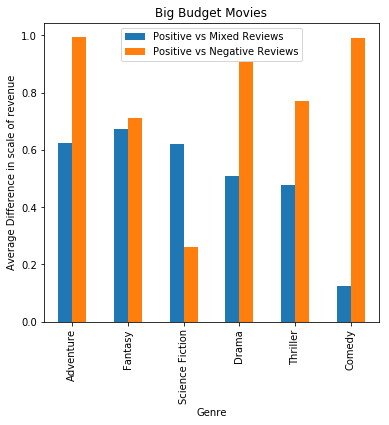

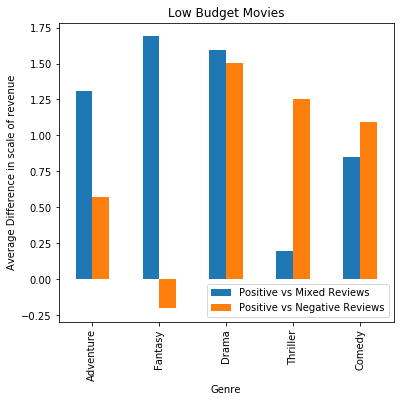

In [43]:
# toplot_full=pd.DataFrame.from_dict(full,orient='index')
# toplot_full
# toplot_full.plot(kind="bar")
import matplotlib.pyplot as plt
toplot_big=pd.DataFrame.from_dict(big_budget,orient='index')
toplot_big.drop(index=['Action','Family','Crime'],inplace=True)
toplot_big.drop(columns=1,inplace=True)
toplot_big.columns=["Positive vs Mixed Reviews","Positive vs Negative Reviews"]
ax_big = toplot_big.plot(kind="bar", title = "Big Budget Movies", figsize = (6, 5.5))
ax_big.set_xlabel("Genre")
ax_big.set_ylabel("Average Difference in scale of revenue")
toplot_small=pd.DataFrame.from_dict(small_budget,orient='index')
toplot_small.drop(index=['Action','Family','Crime','Science Fiction'],inplace=True)
toplot_small.drop(columns=1,inplace=True)
toplot_small.columns=["Positive vs Mixed Reviews","Positive vs Negative Reviews"]
ax_small = toplot_small.plot(kind="bar", title = "Low Budget Movies", figsize = (6, 5.5))
ax_small.set_xlabel("Genre")
ax_small.set_ylabel("Average Difference in scale of revenue")
plt.show()

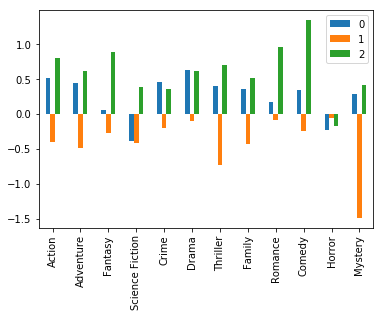

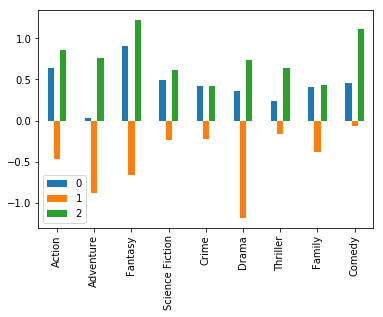

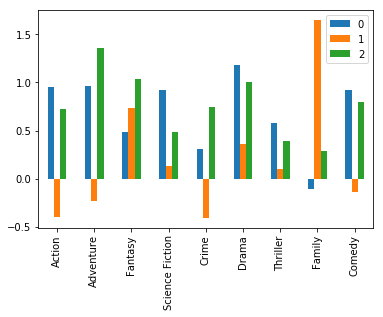

In [142]:
toplot_full=pd.DataFrame.from_dict(full,orient='index')
toplot_full.plot(kind="bar")
toplot_big=pd.DataFrame.from_dict(big_budget,orient='index')
toplot_big.plot(kind="bar")
toplot_small=pd.DataFrame.from_dict(small_budget,orient='index')
toplot_small.plot(kind="bar")
plt.show()

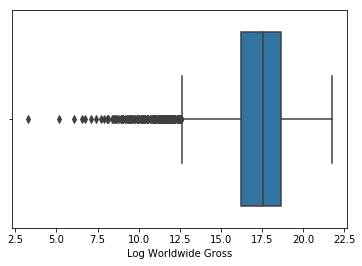

In [48]:
import seaborn as sns
sns.boxplot(critic_cast_revenue['Log Worldwide Gross'])

In [53]:
critic_cast_revenue['Worldwide Gross'].quantile(0.49)

41289976.9